In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('./bursa.mplstyle')

from tb_colormaps import *

donors = [f'TBd{k}' for k in range(1,7)]

######################## PATH CONFIG ################################
FIGURE_OUTDIR = '../../analysis/figures/ed figures'
full_df_loc =  '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
sample_relationships_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
######################## ############ ################################



In [2]:

tissue_indices = {'P':0,
                  'B':1,
                  'L':2,
                  'S':3
                 }
tissue_list = ['PB','BM', 'LN', 'SP']

df = pd.read_table(full_df_loc, usecols = ['cb','sample_uid',
                                            'sample_uid_gex',
                                            'sample_uid_vdj',
                                            'contaminant_status',
                                            'locus',
                                            'vdj_sequence',
                                            'n_umis',
                                            'v_pident',
                                            'tissue',
                                            'donor',
                                            'multiplet_status',
                                            'probable_hq_single_b_cell',
                                            'is_ambient_source',
                                            'vdj_is_from_ambient',
                                            'Immune_All_Low_predicted_labels'], 
                    nrows=None, 
                    low_memory=False)
df['is_gex_sample'] = df.sample_uid_gex.notna()
df_clean = df[(df.probable_hq_single_b_cell) & (df.multiplet_status == 1)& (~(df.vdj_is_from_ambient.astype(bool)))]

In [3]:
df['donor_tissue'] = df['donor'] + "_" + df['tissue']
donor_tissue_availability = df.groupby('donor')['donor_tissue'].unique()

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs", 
    "Plasma cells":"ASCs",
    "Plasmablasts":"ASCs"
}

df_clean["celltype"] = df_clean.Immune_All_Low_predicted_labels.map(lambda x: celltypist_simpler.get(x, x))
abundant_categories = df_clean.celltype.value_counts() > 53
abundant_categories = abundant_categories[abundant_categories==True].index
data = df_clean[df_clean.celltype.isin(abundant_categories)]
data = (
    data.groupby(["donor", "tissue"])
    .celltype.value_counts(normalize=True)
    .rename("fraction")
    .reset_index()
)

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_84516/2732954213.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["celltype"] = df_clean.Immune_All_Low_predicted_labels.map(lambda x: celltypist_simpler.get(x, x))


In [4]:
sample_relationships=pd.read_table(sample_relationships_loc).set_index('sample_uid')
sample_relationships['encapsulation_sibling_sample'] = sample_relationships['encapsulation_sibling_sample'].fillna('')
sample_relationships['emulsion'] = sample_relationships.apply(lambda x: ";".join(sorted([x['sample_uid_vdj'],
                                                                                x['encapsulation_sibling_sample']])),
                                                                                axis=1)

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_84516/744849078.py:140: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0].get_shared_y_axes().join(ax[0], ax[1])


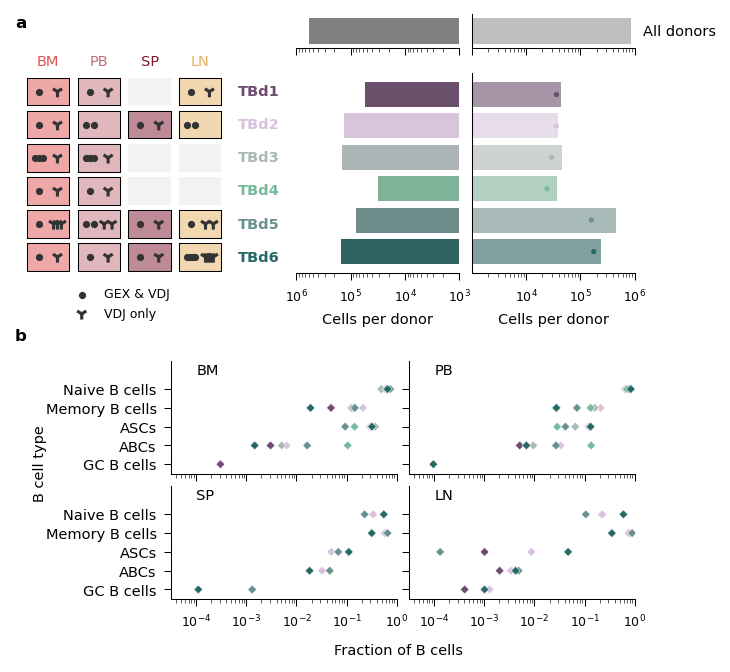

In [18]:
cell_counts_xpos = 1.2
cell_counts_ypos = 0.8
cell_counts_ypos_lower=0.1
cell_counts_ypad = 0.2
cell_counts_xpad = 0.05
cell_counts_width=0.65
totals_height_fraction = 6
donor_id_xpos = 5

celltype_counts_xpos = 0.7
celltype_counts_ypos = -0.7
celltype_counts_width= 0.9
celltype_counts_height= 0.45
celltype_counts_ypos_lower=0.1
celltype_counts_ypad = -0.05
celltype_counts_xpad = 0.05
fig, ax = plt.subplots(6,4,figsize=(1.67,1.67))

plt.text(0.1, 1.1, 'a', horizontalalignment='center',
     fontsize=8, 
     weight='bold',
     verticalalignment='center', transform=fig.transFigure)

plt.text(0.1, -0.15, 'b', horizontalalignment='center',
     fontsize=8, 
     weight='bold',
     verticalalignment='center', transform=fig.transFigure)

celltypeax = [fig.add_axes([celltype_counts_xpos,
                           celltype_counts_ypos,
                           celltype_counts_width,
                            celltype_counts_height],), 
            fig.add_axes([celltype_counts_xpos+celltype_counts_width+celltype_counts_xpad,
                           celltype_counts_ypos,
                           celltype_counts_width,
                           celltype_counts_height]),
             fig.add_axes([celltype_counts_xpos,
                           celltype_counts_ypos+celltype_counts_ypad-celltype_counts_height,
                           celltype_counts_width,
                            celltype_counts_height]), 
              
             fig.add_axes([celltype_counts_xpos+celltype_counts_width+celltype_counts_xpad,
                           celltype_counts_ypos+celltype_counts_ypad - celltype_counts_height,
                           celltype_counts_width,
                           celltype_counts_height])
                ]
for d_it, donor in enumerate(donors):
    donor_tissue_list = [t for t in tissue_list if f'{donor}_{t}' in donor_tissue_availability[donor]]
    for it, tissue in enumerate(tissue_list):
        if tissue in donor_tissue_list:
            r,g,b,a = mpl.colors.to_rgba(tissue_colors[tissue])
            bg_color = (r,g,b,0.5)
            ax[d_it,it].set_facecolor(bg_color)
            emulsions = sample_relationships[sample_relationships.donor_tissue == 
                                                    f'{donor}_{tissue}']
            emulsions = emulsions.groupby(['emulsion','is_gex_sample']).size().reset_index().sort_values('is_gex_sample',
                                                                                                           ascending=False)            # -1 -> 0 white
            # 0->1 gex
            # 1->1.5 white
            # 1.5->2 white
            # 2->3 overload
            # 3->4 white
            filled_center = 0.5
            unfilled_center = 2.5
            circle_color='0.2'
            ax[d_it,it].set_xlim([-0.8, 3.8])
            filled = emulsions.is_gex_sample.values
            if filled.sum() > 0:
                n_filled = filled.sum()
                xs_filled = np.linspace(0,0.85, n_filled) 
                xs_filled = xs_filled - xs_filled.mean() + filled_center
                # print(xs_filled,np.ones(n_filled))
                
                ax[d_it,it].scatter(xs_filled, np.ones(n_filled), 
                                    marker='o', 
                                    ec=circle_color, 
                                    fc=circle_color,
                                    s=12,
                                   lw=0)
                # ax[d_it,it].scatter(xs_filled, np.ones(n_filled), 
                #                     marker='1', 
                #                     ec=circle_color, 
                #                     s=32,
                #                     fc="none",
                #                    lw=1.5)
            if filled.sum() < emulsions.shape[0]:
                xs_unfilled = np.linspace(0,0.85,(~filled.astype(bool)).sum())
                xs_unfilled = xs_unfilled - xs_unfilled.mean() + unfilled_center
                # print(xs_unfilled)
                ax[d_it,it].scatter(xs_unfilled, np.ones((~filled.astype(bool)).sum()), 
                                    marker='1', 
                                    ec=circle_color, 
                                    s=30,
                                    fc="none",
                                   lw=1.5)

        else:
            ax[d_it,it].set_facecolor((0,0,0,0.05))
            for spine in ['bottom', 'left', 'top', 'right']:
                ax[d_it,it].axes.spines[spine].set_visible(False)

        ax[d_it,it].axes.get_xaxis().set_visible(False)
        ax[d_it,it].axes.get_yaxis().set_visible(False)
        ax[0, it].set_title(tissue, color=tissue_colors[tissue], weight='medium')
    ax[d_it,0].text(donor_id_xpos, 0.5, donor, weight='bold', color=donor_colors[donor], va='center', 
                   transform=ax[d_it,0].transAxes, fontsize=7)
circle_color = '0.2'
ax[0,3].scatter([], [], marker='o', 
                        ec=circle_color, 
                        s=12,
                        fc= circle_color,
                        lw=0,
                        label='GEX & VDJ')

ax[0,3].scatter([], [], marker='1', 
                        ec=circle_color, 
                        s=30,
                        fc="none",
                        lw=1.5,
                        label='VDJ only')
ax[0,3].legend(loc='lower right', frameon=False, bbox_to_anchor=(0.05,-8.2))


ax_totals = [fig.add_axes([cell_counts_xpos,
                                 cell_counts_ypos + cell_counts_ypad,
                                 cell_counts_width,
                                 abs(cell_counts_ypos/totals_height_fraction)]),
             fig.add_axes([cell_counts_xpos+cell_counts_width+cell_counts_xpad,
                                 cell_counts_ypos + cell_counts_ypad, 
                                 cell_counts_width,
                                 cell_counts_ypos/totals_height_fraction])]
ax = [fig.add_axes([cell_counts_xpos,
                           0.1,
                           cell_counts_width,
                           cell_counts_ypos]), 
             fig.add_axes([cell_counts_xpos+cell_counts_width+cell_counts_xpad,
                           0.1,
                           cell_counts_width,
                           cell_counts_ypos])]
ax[0].get_shared_y_axes().join(ax[0], ax[1])

cellcounts = df.groupby(['donor','is_gex_sample']).size().reset_index()
unique_vdjs = df.groupby(['donor','is_gex_sample'])['vdj_sequence'].nunique().reset_index()

g=sns.barplot(cellcounts[cellcounts.is_gex_sample==True],
           x=0,
           y='donor',
           palette=donor_colors, 
           ax=ax[0])

g=sns.barplot(cellcounts[cellcounts.is_gex_sample==False],
           x=0,
           y='donor',
           palette=donor_colors, 
           ax=ax[1], 
           alpha=0.6)

g=sns.scatterplot(unique_vdjs[unique_vdjs.is_gex_sample==False],
           x='vdj_sequence',
           y='donor',
           hue='donor',
           marker='.',
           linewidth=0,
           palette=donor_colors, 
           ax=ax[1], 
           alpha=1., 
           legend=False)

ax_totals[0].set_xlabel('')
ax_totals[1].set_xlabel('')
ax[0].set_xlabel('Cells per donor', fontsize=7)
ax[1].set_xlabel('Cells per donor', fontsize=7)

ax[1].set_ylabel('')
ax_totals[1].set_ylabel('')

ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=90)
ax[1].set_yticklabels([])
ax[0].set_ylabel('', fontsize=7)
# ax_totals[1].set_ylabel('Total',fontsize=7, rotation=90)

ax[0].set_xlim([10**6,10**3])
ax[1].set_xlim([10**3,10**6])
ax_totals[0].set_xlim([10**6,10**3])
ax_totals[1].set_xlim([10**3,10**6])

totals=df.groupby('is_gex_sample').size().reset_index()

g=sns.barplot(totals[totals.is_gex_sample==True],
           x=0,
           ax=ax_totals[0],
           color='0.5')
g=sns.barplot(totals[totals.is_gex_sample==False],
           x=0,
           ax=ax_totals[1], 
           alpha=0.5,
           color='0.5')

sns.despine(ax=ax[0], left=True, top=True)
sns.despine(ax=ax[1], right=True, top=True)
sns.despine(ax=ax_totals[0], left=True, top=True, bottom=False)
sns.despine(ax=ax_totals[1], right=True, top=True, bottom=False)

for i in [0,1]:
    ax[i].set_xscale('log')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    ax_totals[i].set_xscale('log')
    ax_totals[i].set_xlabel('')

    ax_totals[i].set_ylim([-0.5,0.5])
    ax_totals[i].set_yticks([])

    # ax_totals[i].set_xticks([])
    # ax_totals[i].set_xticks([], minor=True)
    ax_totals[i].set_xticklabels([])
ax[0].set_xticks([10**3, 10**4, 10**5, 10**6])
ax[1].set_xticks([10**4, 10**5, 10**6])
ax[1].set_xlim([10**3, 10**6])

ax_totals[1].yaxis.label.set(rotation='horizontal', ha='right');
ax_totals[1].text(1.05, 0.5, 'All donors', va='center', fontsize=7, transform=ax_totals[1].transAxes)
# fig.tight_layout(h_pad=-0.9, pad=10)


tissue_list = ['BM','PB','SP','LN']
b_cells=df_clean
celltypes = b_cells.groupby(['donor','tissue', 'Immune_All_Low_predicted_labels']).size()
celltypes = celltypes.reset_index().rename(columns={0:'count',
                                                   'Immune_All_Low_predicted_labels':'celltype'})
celltypes = celltypes.pivot(index=['donor','tissue'], 
                            columns='celltype',
                            values='count').fillna(0)
celltypes = celltypes.T[celltypes.sum(axis=0) > 40].T
cell_counts = (celltypes.T/celltypes.sum(axis=1)).T.reset_index()
cell_counts = cell_counts.melt(id_vars = ['donor', 'tissue'],
                                value_vars=[x for x in cell_counts.columns
                                                                    if not (x in ['donor',
                                                                                  'tissue'])],
                              value_name='fraction')



celltypist_rank = data.groupby('celltype')['fraction'].mean().sort_values(ascending=True).reset_index().reset_index()
celltypist_rank = celltypist_rank.set_index('celltype')['index']


data['celltypist_rank'] = data['celltype'].map(celltypist_rank)

for i, axes in enumerate(celltypeax):
    tissue = tissue_list[i]
    sns.scatterplot(data[data.tissue==tissue], 
                  y='celltypist_rank', 
                  x='fraction', 
                  hue='donor', 
                  ax=axes, 
                  legend=False, 
                  palette=donor_colors, 
                  marker='D',
                 s=9)
    sns.despine(ax=axes)
    axes.set_xlim([10**-4.5,1])
    axes.set_xscale('log')
 
    axes.set_ylim([-0.5, 5.5])
    if i in [0,1]:
        axes.set_xticklabels([])

    if i in [1,3]:
        axes.set_yticks(celltypist_rank.values, [], fontsize=7) 
    else:
        axes.set_yticks(celltypist_rank.values, celltypist_rank.index, fontsize=7) 

    axes.text(10**-4,5,tissue, transform=axes.transData, va='center', weight='medium')

    axes.set_xlabel('')
    axes.set_ylabel('')

plt.text(0.15, -0.8, 'B cell type', transform=fig.transFigure, rotation=90)

plt.text(1.35, -1.42, 'Fraction of B cells', transform=fig.transFigure)
fig.savefig('../figures/paper figures/Figure1_ab.pdf', bbox_inches='tight')
